In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

## Dataset loading

### Regular dataset loading

In [2]:
from python_proj.utils.util import Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_nftc/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [3]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

,ID,Project Name,Submitter ID,PR Number,Closed At,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1216221.0,1216221.0,1216221.0,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,9.081164e+05,8.677039e+03,0.0,0.0,0.0,5.027905e-01,4.027001e-01,9.860918e-02,3.749753e-01,5.920373e-02,...,1.145965e-02,1.972030e-02,7.959556e-02,1.343719e-01,9.534855e-03,1.751229e-02,6.396949e-02,6.042839e-02,2.191224e-02,4.468485e-02
std,5.243531e+05,5.806587e+03,0.0,0.0,0.0,4.710578e-01,4.523420e-01,2.908001e-01,4.479160e-01,2.284681e-01,...,5.401390e-02,8.011601e-02,1.179346e-01,1.749533e-01,5.258916e-02,8.239552e-02,9.937732e-02,1.003326e-01,8.736962e-02,1.013914e-01
min,0.000000e+00,4.300000e+01,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.542500e+05,3.224000e+03,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.078700e+05,8.413000e+03,0.0,0.0,0.0,6.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,8.438514e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.362318e+06,1.357000e+04,0.0,0.0,0.0,1.000000e+00,9.387755e-01,0.000000e+00,9.230769e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,9.891430e-02,8.847414e-02,0.000000e+00,2.582313e-02
max,1.815970e+06,2.009400e+04,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
print(list(df.columns))

['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At', 'PullRequestIsMerged', 'ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystem

In [5]:
intra_collab_fields = [
    "ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality)",
    "ln(1 + IntraProjectLinkIntensity)",
]

df = df.drop(intra_collab_fields, axis=1)

In [6]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [7]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

class_imbalance=3.6988274383294377


### Sample only PRs by first-time contributors

In [8]:
# Filters data
df = df[df[ftc_key] == True]
df = df.drop([ftc_key], axis=1)
independent_fields.remove(ftc_key)
print(f"{len(df)=}")

# Recalculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

# Resets indices.
df = df.reset_index(drop=True)
print(independent_fields)

df.describe()

len(df)=427085
class_imbalance=1.9255002157726373
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosy

,ID,Project Name,Submitter ID,PR Number,Closed At,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,...,ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity)
count,4.270850e+05,427085.000000,427085.0,427085.0,427085.0,427085.0,427085.000000,427085.000000,427085.000000,427085.000000,...,427085.000000,427085.000000,427085.000000,427085.000000,427085.000000,427085.000000,427085.000000,427085.000000,427085.000000,427085.000000
mean,9.073976e+05,7127.171032,0.0,0.0,0.0,0.0,0.265283,0.023956,0.256446,0.024830,...,0.060157,0.098302,0.002769,0.004918,0.057654,0.094553,0.004177,0.007874,0.048772,0.012940
std,5.244681e+05,5528.613961,0.0,0.0,0.0,0.0,0.409457,0.149628,0.405476,0.150583,...,0.104294,0.153440,0.025460,0.040142,0.101331,0.149739,0.033534,0.054307,0.089011,0.064526
min,4.000000e+00,43.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.528710e+05,2106.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.075840e+05,6296.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.361581e+06,11408.000000,0.0,0.0,0.0,0.0,0.666667,0.000000,0.648649,0.000000,...,0.089382,0.155067,0.000000,0.000000,0.089382,0.155067,0.000000,0.000000,0.064858,0.000000
max,1.815970e+06,20094.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.759557,1.000000,1.000000,1.000000,1.000000,0.999543,1.000000,0.951250


## Model Creation

In [9]:
k = 5
print(f"Using {k=} folds.")

Using k=5 folds.


Generates a number of feature groups that are relevant later in the pipeline:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

In [10]:
from enum import Enum
from python_proj.utils.util import get_matching

# Defines feature groups


class FeatureGroups(Enum):
    Control = 1
    Intra = 2
    Eco = 3
    DEco = 4
    IDEco = 5
    NDEco = 6
    Coll = 7


var_group_regex_patterns = [
    (FeatureGroups.Control, r".*Control.*"),
    (
        FeatureGroups.Intra,
        r"^(?:(?!Control|Degree|Link).)*Intra(?:(?!Control|Degree|Link).)*$",
    ),
    (FeatureGroups.Eco, r"^(?:(?!Dependency).)*Ecosystem(?:(?!Degree|Link).)*$"),
    (FeatureGroups.DEco, r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    (FeatureGroups.IDEco, r".*(?=Inverse).*"),
    (FeatureGroups.NDEco, r".*(?=NonDependency).*"),
    (FeatureGroups.Coll, r"^(?:(?!Intra).)*(Weighted|LinkIntensity)(?:(?!Intra).)*$"),
]

# Resolves the regex patterns to generate lists of fields.
var_groups = {
    str(name): list(get_matching(independent_fields, pattern))
    for name, pattern in var_group_regex_patterns
}


print("Feature groups:")
print(json.dumps(var_groups, indent=2))

Feature groups:
{
  "FeatureGroups.Control": [
    "ControlIntegratedBySameUser",
    "ControlPullRequestHasComments",
    "ControlPullRequestHasCommentByExternalUser",
    "ControlHasHashTagInDescription",
    "ln(1 + ControlPullRequestLifeTimeInMinutes)",
    "ln(1 + ControlNumberOfCommitsInPullRequest)",
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)"
  ],
  "FeatureGroups.Intra": [
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)"
  ],
  "FeatureGroups.Eco": [
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + Ecosyst

In [11]:
from wmutils.collections.list_access import flatten


def get_feature_groups(*feature_groups) -> list[str]:
    return list(flatten(var_groups[str(group)] for group in feature_groups))

### Full Model

In [12]:
from python_proj.modelling.notebooks.random_forest.rf_functions import (
    kfold_rf_evaluation,
)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43

random_state=43

random_state=43

random_state=43

random_state=43

metrics={'accuracy': 0.766627252186333, 'precision': 0.7922275187848429, 'recall': 0.8738748373527262, 'f1': 0.8310506153168118}


Confusion matrix:
[[16456 12858]
 [ 7076 49027]]


Classification report:

              precision    recall  f1-score   support

       False       0.70      0.56      0.62     29314
        True       0.79      0.87      0.83     56103

    accuracy                           0.77     85417
   macro avg       0.75      0.72      0.73     85417
weighted avg       0.76      0.77      0.76     85417


metrics={'accuracy': 0.7654916468618659, 'precision': 0.7931837289012481, 'recall': 0.8714186752873053, 'f1': 0.8304627129689973}


Confusion matrix:
[[16326 12792]
 [ 7239 49060]]


Classification report:

metrics={'accuracy': 0.7672009084842596, 'precision': 0.794295410471881, 'recall': 0.8729110057364093, 'f1': 0.8317496848215118}


Confusion matrix:
[[16381 12729]
 [ 7156 49151]]


Classification report:

              precision    recall  f1-score   support

       False       0.69      0.56      0.62     29118
        True       0.79      0.87      0.83     56299

    accuracy                           0.77     85417
   macro avg       0.74      0.72      0.73     85417
weighted avg       0.76      0.77      0.76     85417


              precision    recall  f1-score   support

       False       0.70      0.56      0.62     29110
        True       0.79      0.87      0.83     56307

    accuracy                           0.77     85417
   macro avg       0.75      0.72      0.73     85417
weighted avg       0.76      0.77      0.76     85417


metrics={'accuracy': 0.76594823044593, 'precision': 0.7915554908714565, 'recall': 0.8732939644252555, 'f1': 0.830418186444991}


Confusion matrix:
[[16476 12890]
 [ 7102 48949]]


Classification report:

              precision    recall  f1-score   support

       False       0.70      0.56      0.62     29366
        True       0.79      0.87      0.83     56051

    accuracy                           0.77     85417
   macro avg       0.75      0.72      0.73     85417
weighted avg       0.76      0.77      0.76     85417


metrics={'accuracy': 0.7652457941627545, 'precision': 0.7927517991415755, 'recall': 0.872057936028968, 'f1': 0.8305159239975657}


Confusion matrix:
[[16235 12844]
 [ 7208 49130]]


Classification report:

              precision    recall  f1-score   support

       False       0.69      0.56      0.62     29079
        True       0.79      0.87      0.83     56338

    accuracy                           0.77     85417
   macro avg       0.74      0.72      0.72     85417
weighted avg       0.76      0.77      0.76     85417



Performance metrics full model:
f1_scores=[0.8310506153168118, 0.8304627129689973, 0.8317496848215118, 0.830418186444991, 0.8305159239975657]
f1_mean=0.8308394247099755, f1_std=0.0005093488128341074


### Control + Intra-project Model

In [13]:
contr_with_intra = get_feature_groups(FeatureGroups.Control, FeatureGroups.Intra)
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, contr_with_intra, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']


random_state=45

random_state=45

random_state=45

random_state=45

random_state=45

metrics={'accuracy': 0.736094688410972, 'precision': 0.7819159596499432, 'recall': 0.8315512770416682, 'f1': 0.8059701492537314}


Confusion matrix:
[[16057 13058]
 [ 9484 46818]]


Classification report:

              precision    recall  f1-score   support

       False       0.63      0.55      0.59     29115
        True       0.78      0.83      0.81     56302

    accuracy                           0.74     85417
   macro avg       0.71      0.69      0.70     85417
weighted avg       0.73      0.74      0.73     85417


metrics={'accuracy': 0.7384127281454511, 'precision': 0.7815308953760779, 'recall': 0.8364839151387975, 'f1': 0.8080742140525683}


Confusion matrix:
[[16035 13149]
 [ 9195 47038]]


Classification report:

              precision    recall  f1-score   support

       False       0.64      0.55      0.59     29184
        True       0.78      0.84      0.81     56233

    accuracy                           0.74     85417
   macro avg       0.71      0.69      0.70     85417
weighted avg       0.73      0.74      0.73     85417


metrics={'accuracy': 0.7380380954610909, 'precision': 0.7820946790948958, 'recall': 0.8344096351247976, 'f1': 0.8074056222134237}


Confusion matrix:
[[16138 13068]
 [ 9308 46903]]


Classification report:

              precision    recall  f1-score   support

       False       0.63      0.55      0.59     29206
        True       0.78      0.83      0.81     56211

    accuracy                           0.74     85417
   macro avg       0.71      0.69      0.70     85417
weighted avg       0.73      0.74      0.73     85417


metrics={'accuracy': 0.7366449301661262, 'precision': 0.7810257861530522, 'recall': 0.8339613921575598, 'f1': 0.8066260347806652}


Confusion matrix:
[[16005 13154]
 [ 9341 46917]]


Classification report:

metrics={'accuracy': 0.7392439444138754, 'precision': 0.7807793846613645, 'recall': 0.8383071273219952, 'f1': 0.8085212472382459}


Confusion matrix:
[[16120 13203]
 [ 9070 47024]]


Classification report:

              precision    recall  f1-score   support

       False       0.63      0.55      0.59     29159
        True       0.78      0.83      0.81     56258

    accuracy                           0.74     85417
   macro avg       0.71      0.69      0.70     85417
weighted avg       0.73      0.74      0.73     85417


              precision    recall  f1-score   support

       False       0.64      0.55      0.59     29323
        True       0.78      0.84      0.81     56094

    accuracy                           0.74     85417
   macro avg       0.71      0.69      0.70     85417
weighted avg       0.73      0.74      0.73     85417



Performance metrics control + intra model:
f1_scores=[0.8059701492537314, 0.8080742140525683, 0.8074056222134237, 0.8066260347806652, 0.8085212472382459]
f1_mean=0.8073194535077268, f1_std=0.0009298223698638006


### Collaboration and Ecosystem Model

In [14]:
non_control_intra_fields = get_feature_groups(
    FeatureGroups.Eco,
    FeatureGroups.DEco,
    FeatureGroups.IDEco,
    FeatureGroups.NDEco,
    FeatureGroups.Coll,
)
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, non_control_intra_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosyste

random_state=47

random_state=47

random_state=47

random_state=47

random_state=47

metrics={'accuracy': 0.6377887305805636, 'precision': 0.6574945782301839, 'recall': 0.9354867477615667, 'f1': 0.772234369133594}


Confusion matrix:
[[ 2029 27322]
 [ 3617 52449]]


Classification report:

              precision    recall  f1-score   support

       False       0.36      0.07      0.12     29351
        True       0.66      0.94      0.77     56066

    accuracy                           0.64     85417
   macro avg       0.51      0.50      0.44     85417
weighted avg       0.56      0.64      0.55     85417


metrics={'accuracy': 0.6428111500052682, 'precision': 0.6627217448112971, 'recall': 0.9350515829404049, 'f1': 0.7756782589515477}


Confusion matrix:
[[ 2157 26846]
 [ 3664 52750]]


Classification report:

              precision    recall  f1-score   support

       False       0.37      0.07      0.12     29003
        True       0.66      0.94      0.78     56414

    accuracy                           0.64     85417
   macro avg       0.52      0.50      0.45     85417
weighted avg       0.56      0.64      0.55     85417


metrics={'accuracy': 0.6403994520996992, 'precision': 0.6611947620664931, 'recall': 0.9328778063714616, 'f1': 0.7738843656601052}


Confusion matrix:
[[ 2138 26934]
 [ 3782 52563]]


Classification report:

              precision    recall  f1-score   support

       False       0.36      0.07      0.12     29072
        True       0.66      0.93      0.77     56345

    accuracy                           0.64     85417
   macro avg       0.51      0.50      0.45     85417
weighted avg       0.56      0.64      0.55     85417


metrics={'accuracy': 0.6380579978224475, 'precision': 0.6582690422938707, 'recall': 0.9337171169886647, 'f1': 0.7721638392264949}


Confusion matrix:
[[ 2112 27197]
 [ 3719 52389]]


Classification report:

              precision    recall  f1-score   support

       False       0.36      0.07      0.12     29309
        True       0.66      0.93      0.77     56108

    accuracy                           0.64     85417
   macro avg       0.51      0.50      0.45     85417
weighted avg       0.56      0.64      0.55     85417


metrics={'accuracy': 0.6390297013475069, 'precision': 0.6589209535759096, 'recall': 0.9350307130775394, 'f1': 0.7730614948662275}


Confusion matrix:
[[ 2068 27184]
 [ 3649 52516]]


Classification report:

              precision    recall  f1-score   support

       False       0.36      0.07      0.12     29252
        True       0.66      0.94      0.77     56165

    accuracy                           0.64     85417
   macro avg       0.51      0.50      0.45     85417
weighted avg       0.56      0.64      0.55     85417



Performance metrics non-control model:
f1_scores=[0.772234369133594, 0.7756782589515477, 0.7738843656601052, 0.7721638392264949, 0.7730614948662275]
f1_mean=0.7734044655675939, f1_std=0.0012981793972166036


## Feature Explanation and Evaluation

### Model Creation

In [15]:
from sklearn.model_selection import train_test_split

from python_proj.modelling.notebooks.random_forest.rf_functions import create_model


train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]


full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent, seed_counter
)

random_state=49


metrics={'accuracy': 0.7665570085580153, 'precision': 0.7931923170435206, 'recall': 0.872035212146052, 'f1': 0.8307472922962008}

Confusion matrix:
[[16541 12759]
 [ 7181 48936]]

Classification report:
              precision    recall  f1-score   support

       False       0.70      0.56      0.62     29300
        True       0.79      0.87      0.83     56117

    accuracy                           0.77     85417
   macro avg       0.75      0.72      0.73     85417
weighted avg       0.76      0.77      0.76     85417



### Mean decrease in Impurity

/tmp/ipykernel_104019/1648129876.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


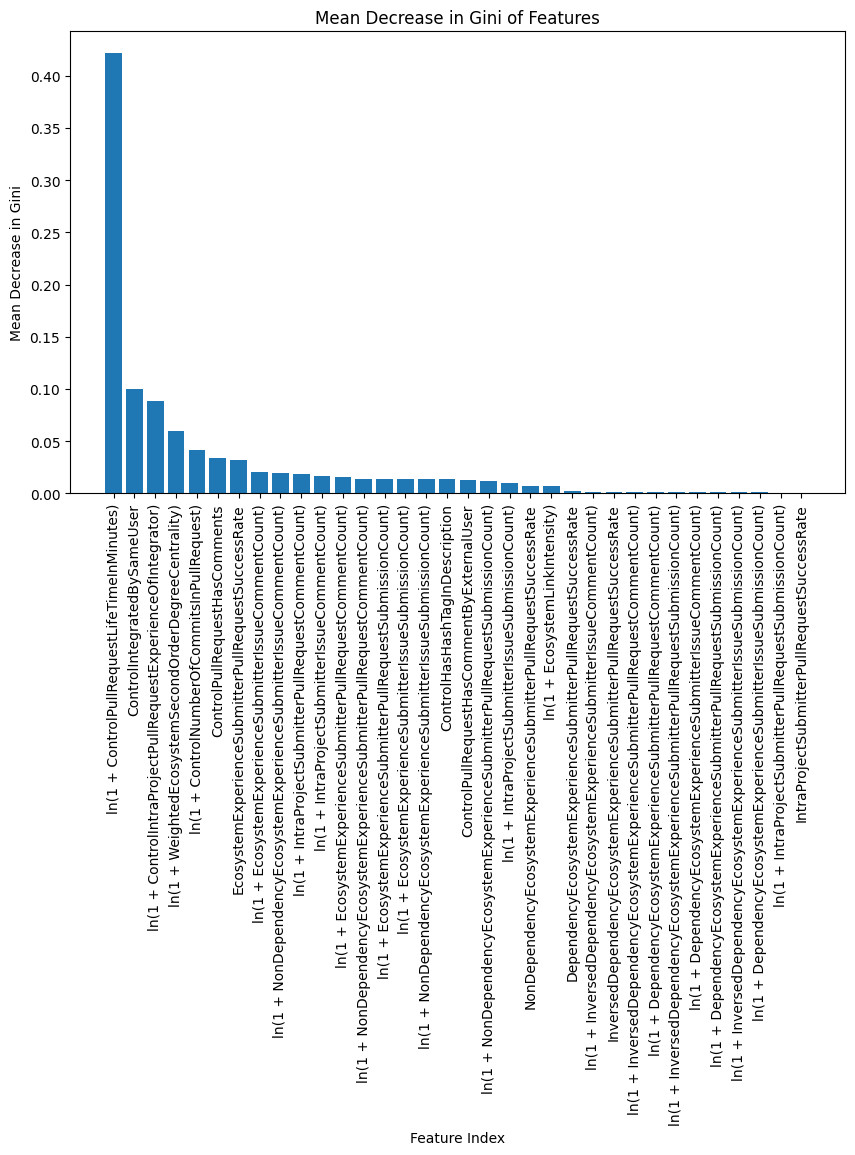

In [16]:
from matplotlib import pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

In [17]:
# Stores feature importances in file.
output_file = f"{figure_base_path}/feature_importance.txt"
with open(output_file, "w+", encoding="utf-8") as output_file:
    for field, importance in zip(ordererd_columns, sorted_importances):
        entry = f"{field}: {importance}"
        output_file.write(f'{entry}\n')
        print(entry)

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.4215065413321492
ControlIntegratedBySameUser: 0.09999691397240791
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.08849968391022102
ln(1 + WeightedEcosystemSecondOrderDegreeCentrality): 0.05926974470515328
ln(1 + ControlNumberOfCommitsInPullRequest): 0.041865486825591096
ControlPullRequestHasComments: 0.03432197360312389
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.031558272193249456
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.020551645267282082
ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount): 0.019771860278340502
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.018743245740212418
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.016393117387124873
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount): 0.015394228614531054
ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount): 0.014031531178270154
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissio

### Variable Group Reverse Ablation Studies

Creates a model with a subset of features.
Compared to regular ablation, it tests "what happens if I add a feature", instead of "what happens when I remove one".

In [18]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups.items():
    print(f'Reverse ablation with "{str(cluster_name)}", including: {cluster}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Reverse ablation with "FeatureGroups.Control", including: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].


random_state=50

random_state=50

random_state=50

random_state=50

random_state=50

metrics={'accuracy': 0.724293758853624, 'precision': 0.7759862951579584, 'recall': 0.8189843126827971, 'f1': 0.7969057228603953}


Confusion matrix:
[[15664 13338]
 [10212 46203]]


Classification report:

              precision    recall  f1-score   support

       False       0.61      0.54      0.57     29002
        True       0.78      0.82      0.80     56415

    accuracy                           0.72     85417
   macro avg       0.69      0.68      0.68     85417
weighted avg       0.72      0.72      0.72     85417


metrics={'accuracy': 0.7251483896648209, 'precision': 0.7740918919825, 'recall': 0.822000711997152, 'f1': 0.7973272788487271}


Confusion matrix:
[[15760 13477]
 [10000 46180]]


Classification report:

metrics={'accuracy': 0.7229357153728181, 'precision': 0.7716916380681342, 'recall': 0.8213273942093541, 'f1': 0.79573623338512}


Confusion matrix:
[[15654 13638]
 [10028 46097]]


Classification report:

              precision    recall  f1-score   support

       False       0.61      0.54      0.57     29237
        True       0.77      0.82      0.80     56180

    accuracy                           0.73     85417
   macro avg       0.69      0.68      0.69     85417
weighted avg       0.72      0.73      0.72     85417


metrics={'accuracy': 0.7213669410070594, 'precision': 0.7705427912109963, 'recall': 0.8205420420955162, 'f1': 0.7947568126940323}


Confusion matrix:
[[15537 13722]
 [10078 46080]]


Classification report:

              precision    recall  f1-score   support

       False       0.61      0.53      0.57     29292
        True       0.77      0.82      0.80     56125

    accuracy                           0.72     85417
   macro avg       0.69      0.68      0.68     85417
weighted avg       0.72      0.72      0.72     85417


metrics={'accuracy': 0.7244927824671904, 'precision': 0.7744177846432829, 'recall': 0.820384204909285, 'f1': 0.7967385577446298}


Confusion matrix:
[[15762 13435]
 [10098 46122]]


Classification report:

              precision    recall  f1-score   support

       False       0.61      0.53      0.57     29259
        True       0.77      0.82      0.79     56158

    accuracy                           0.72     85417
   macro avg       0.69      0.68      0.68     85417
weighted avg       0.71      0.72      0.72     85417


              precision    recall  f1-score   support

       False       0.61      0.54      0.57     29197
        True       0.77      0.82      0.80     56220

    accuracy                           0.72     85417
   macro avg       0.69      0.68      0.68     85417
weighted avg       0.72      0.72      0.72     85417


Performance of 'FeatureGroups.Control'
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)']
f1_scores=[0.7969057228603953, 0.7973272788487271, 0.79573623338512, 0.7947568126940323, 0.7967385577446298]
f1_mean=0.7962929211065809, f1_std=0.0009288212116134273

Reverse ablation with "FeatureGroups.Intra", including: ['IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)'].


random_state=52

random_state=52

random_state=52

random_state=52

random_state=52

metrics={'accuracy': 0.6590491354180081, 'precision': 0.6594974096908038, 'recall': 0.9987220220451197, 'f1': 0.7944118539853308}


Confusion matrix:
[[   27 29051]
 [   72 56267]]


Classification report:

metrics={'accuracy': 0.656731095683529, 'precision': 0.6572476677136562, 'recall': 0.99864660315199, 'f1': 0.7927536948946486}


Confusion matrix:
[[   17 29245]
 [   76 56079]]


Classification report:

metrics={'accuracy': 0.657047192010958, 'precision': 0.6575236487674508, 'recall': 0.9986291858788343, 'f1': 0.7929489263651914}


Confusion matrix:
[[   29 29217]
 [   77 56094]]


Classification report:

metrics={'accuracy': 0.6582647482351288, 'precision': 0.658582898669636, 'recall': 0.9988977581823677, 'f1': 0.7938035093667882}


Confusion matrix:
[[   40 29128]
 [   62 56187]]


Classification report:

metrics={'accuracy': 0.6570940210965031, 'precision': 0.657632522917497, 'recall': 0.9985049124305853, 'f1': 0.7929889038094564}


Confusion matrix:
[[   27 29206]
 [   84 56100]]


Classification report:

              precision    recall  f1-score   support

       False       0.27      0.00      0.00     29078
        True       0.66      1.00      0.79     56339

    accuracy                           0.66     85417
   macro avg       0.47      0.50      0.40     85417
weighted avg       0.53      0.66      0.52     85417


              precision    recall  f1-score   support

       False       0.18      0.00      0.00     29262
        True       0.66      1.00      0.79     56155

    accuracy                           0.66     85417
   macro avg       0.42      0.50      0.40     85417
weighted avg       0.49      0.66      0.52     85417


              precision    recall  f1-score   support

       False       0.27      0.00      0.00     29246
        True       0.66      1.00      0.79     56171

    accuracy                           0.66     85417
   macro avg       0.47      0.50      0.40     85417
weighted avg       0.53      0.66      0.52     85417


              precision    recall  f1-score   support

       False       0.39      0.00      0.00     29168
        True       0.66      1.00      0.79     56249

    accuracy                           0.66     85417
   macro avg       0.53      0.50      0.40     85417
weighted avg       0.57      0.66      0.52     85417


              precision    recall  f1-score   support

       False       0.24      0.00      0.00     29233
        True       0.66      1.00      0.79     56184

    accuracy                           0.66     85417
   macro avg       0.45      0.50      0.40     85417
weighted avg       0.52      0.66      0.52     85417


Performance of 'FeatureGroups.Intra'
['IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']
f1_scores=[0.7944118539853308, 0.7927536948946486, 0.7929489263651914, 0.7938035093667882, 0.7929889038094564]
f1_mean=0.7933813776842832, f1_std=0.0006285080961458457

Reverse ablation with "FeatureGroups.Eco", including: ['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)'].


random_state=54

random_state=54

random_state=54

random_state=54

random_state=54

metrics={'accuracy': 0.6464169895922357, 'precision': 0.6584055923616524, 'recall': 0.9617012950049808, 'f1': 0.7816638713781736}


Confusion matrix:
[[ 1152 28049]
 [ 2153 54063]]


Classification report:

metrics={'accuracy': 0.6488403947691912, 'precision': 0.6602762417480694, 'recall': 0.9626551595546321, 'f1': 0.7832966080265866}


Confusion matrix:
[[ 1212 27892]
 [ 2103 54210]]


Classification report:

              precision    recall  f1-score   support

       False       0.35      0.04      0.07     29201
        True       0.66      0.96      0.78     56216

    accuracy                           0.65     85417
   macro avg       0.50      0.50      0.43     85417
weighted avg       0.55      0.65      0.54     85417


              precision    recall  f1-score   support

       False       0.37      0.04      0.07     29104
        True       0.66      0.96      0.78     56313

    accuracy                           0.65     85417
   macro avg       0.51      0.50      0.43     85417
weighted avg       0.56      0.65      0.54     85417


metrics={'accuracy': 0.6451408970111336, 'precision': 0.6569078386994719, 'recall': 0.9623001372524554, 'f1': 0.7808045819081161}


Confusion matrix:
[[ 1120 28196]
 [ 2115 53986]]


Classification report:

metrics={'accuracy': 0.6473652785745226, 'precision': 0.6580980611302785, 'recall': 0.9647901120233664, 'f1': 0.7824648828223739}


Confusion matrix:
[[ 1124 28144]
 [ 1977 54172]]


Classification report:

              precision    recall  f1-score   support

       False       0.35      0.04      0.07     29316
        True       0.66      0.96      0.78     56101

    accuracy                           0.65     85417
   macro avg       0.50      0.50      0.42     85417
weighted avg       0.55      0.65      0.54     85417


              precision    recall  f1-score   support

       False       0.36      0.04      0.07     29268
        True       0.66      0.96      0.78     56149

    accuracy                           0.65     85417
   macro avg       0.51      0.50      0.43     85417
weighted avg       0.56      0.65      0.54     85417


metrics={'accuracy': 0.6493906365243453, 'precision': 0.6604094940327742, 'recall': 0.9638843019229745, 'f1': 0.7837970516467174}


Confusion matrix:
[[ 1184 27914]
 [ 2034 54285]]


Classification report:

              precision    recall  f1-score   support

       False       0.37      0.04      0.07     29098
        True       0.66      0.96      0.78     56319

    accuracy                           0.65     85417
   macro avg       0.51      0.50      0.43     85417
weighted avg       0.56      0.65      0.54     85417


Performance of 'FeatureGroups.Eco'
['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.7816638713781736, 0.7832966080265866, 0.7808045819081161, 0.7824648828223739, 0.7837970516467174]
f1_mean=0.7824053991563935, f1_std=0.0010813849933218394

Reverse ablation with "FeatureGroups.DEco", including: ['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)'].


random_state=56

random_state=56

random_state=56

random_state=56

random_state=56

metrics={'accuracy': 0.6603720570846553, 'precision': 0.6607616010504842, 'recall': 0.998671013927774, 'f1': 0.7953121472115601}


Confusion matrix:
[[   48 28935]
 [   75 56359]]


Classification report:

metrics={'accuracy': 0.656684266597984, 'precision': 0.6570604511560287, 'recall': 0.9986635066022774, 'f1': 0.7926228175010077}


Confusion matrix:
[[   50 29250]
 [   75 56042]]


Classification report:

metrics={'accuracy': 0.6582881627779014, 'precision': 0.6587464394143643, 'recall': 0.9986494411174097, 'f1': 0.7938438502069473}


Confusion matrix:
[[   32 29112]
 [   76 56197]]


Classification report:

              precision    recall  f1-score   support

       False       0.39      0.00      0.00     28983
        True       0.66      1.00      0.80     56434

    accuracy                           0.66     85417
   macro avg       0.53      0.50      0.40     85417
weighted avg       0.57      0.66      0.53     85417


metrics={'accuracy': 0.6562862193708512, 'precision': 0.6565859033418903, 'recall': 0.9988943576574648, 'f1': 0.7923500746178928}


Confusion matrix:
[[   44 29297]
 [   62 56014]]


Classification report:

              precision    recall  f1-score   support

       False       0.40      0.00      0.00     29300
        True       0.66      1.00      0.79     56117

    accuracy                           0.66     85417
   macro avg       0.53      0.50      0.40     85417
weighted avg       0.57      0.66      0.52     85417


metrics={'accuracy': 0.6575740192233396, 'precision': 0.6579382289163688, 'recall': 0.9988255809815296, 'f1': 0.7933122751973317}


Confusion matrix:
[[   36 29183]
 [   66 56132]]


Classification report:

              precision    recall  f1-score   support

       False       0.30      0.00      0.00     29144
        True       0.66      1.00      0.79     56273

    accuracy                           0.66     85417
   macro avg       0.48      0.50      0.40     85417
weighted avg       0.54      0.66      0.52     85417


              precision    recall  f1-score   support

       False       0.42      0.00      0.00     29341
        True       0.66      1.00      0.79     56076

    accuracy                           0.66     85417
   macro avg       0.54      0.50      0.40     85417
weighted avg       0.57      0.66      0.52     85417


              precision    recall  f1-score   support

       False       0.35      0.00      0.00     29219
        True       0.66      1.00      0.79     56198

    accuracy                           0.66     85417
   macro avg       0.51      0.50      0.40     85417
weighted avg       0.55      0.66      0.52     85417


Performance of 'FeatureGroups.DEco'
['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.7953121472115601, 0.7926228175010077, 0.7938438502069473, 0.7923500746178928, 0.7933122751973317]
f1_mean=0.7934882329469479, f1_std=0.0010515166461815672

Reverse ablation with "FeatureGroups.IDEco", including: ['InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)

random_state=58

random_state=58

random_state=58

random_state=58

random_state=58

metrics={'accuracy': 0.6577145064799748, 'precision': 0.6585394485074013, 'recall': 0.9973510169250462, 'f1': 0.7932831335949375}


Confusion matrix:
[[   81 29088]
 [  149 56099]]


Classification report:

metrics={'accuracy': 0.6596344989873211, 'precision': 0.6603432700993677, 'recall': 0.9978549141965679, 'f1': 0.7947503300458182}


Confusion matrix:
[[   57 28952]
 [  121 56287]]


Classification report:

              precision    recall  f1-score   support

       False       0.35      0.00      0.01     29169
        True       0.66      1.00      0.79     56248

    accuracy                           0.66     85417
   macro avg       0.51      0.50      0.40     85417
weighted avg       0.55      0.66      0.52     85417


              precision    recall  f1-score   support

       False       0.32      0.00      0.00     29009
        True       0.66      1.00      0.79     56408

    accuracy                           0.66     85417
   macro avg       0.49      0.50      0.40     85417
weighted avg       0.54      0.66      0.53     85417


metrics={'accuracy': 0.6583115773206739, 'precision': 0.6590583706902622, 'recall': 0.9976374036309376, 'f1': 0.7937501766684569}


Confusion matrix:
[[   70 29053]
 [  133 56161]]


Classification report:

              precision    recall  f1-score   support

       False       0.34      0.00      0.00     29123
        True       0.66      1.00      0.79     56294

    accuracy                           0.66     85417
   macro avg       0.50      0.50      0.40     85417
weighted avg       0.55      0.66      0.52     85417


metrics={'accuracy': 0.657866701007996, 'precision': 0.6584862277696965, 'recall': 0.9980086764810469, 'f1': 0.7934524482641638}


Confusion matrix:
[[   61 29112]
 [  112 56132]]


Classification report:

metrics={'accuracy': 0.654143788707166, 'precision': 0.6547247329498768, 'recall': 0.9977103606182026, 'f1': 0.7906218549335904}


Confusion matrix:
[[   99 29414]
 [  128 55776]]


Classification report:

              precision    recall  f1-score   support

       False       0.35      0.00      0.00     29173
        True       0.66      1.00      0.79     56244

    accuracy                           0.66     85417
   macro avg       0.51      0.50      0.40     85417
weighted avg       0.55      0.66      0.52     85417


              precision    recall  f1-score   support

       False       0.44      0.00      0.01     29513
        True       0.65      1.00      0.79     55904

    accuracy                           0.65     85417
   macro avg       0.55      0.50      0.40     85417
weighted avg       0.58      0.65      0.52     85417


Performance of 'FeatureGroups.IDEco'
['InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.7932831335949375, 0.7947503300458182, 0.7937501766684569, 0.7934524482641638, 0.7906218549335904]
f1_mean=0.7931715887013934, f1_std=0.0013725636533273948

Reverse ablation with "FeatureGroups.NDEco", including: ['NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIs

random_state=60

random_state=60

random_state=60

random_state=60

random_state=60

metrics={'accuracy': 0.6478335694299729, 'precision': 0.6594446065557825, 'recall': 0.963220799516951, 'f1': 0.7828980130920847}


Confusion matrix:
[[ 1098 28010]
 [ 2071 54238]]


Classification report:

metrics={'accuracy': 0.6487935656836461, 'precision': 0.6583558686926257, 'recall': 0.9674602608881603, 'f1': 0.7835241991932399}


Confusion matrix:
[[ 1128 28173]
 [ 1826 54290]]


Classification report:

              precision    recall  f1-score   support

       False       0.35      0.04      0.07     29108
        True       0.66      0.96      0.78     56309

    accuracy                           0.65     85417
   macro avg       0.50      0.50      0.43     85417
weighted avg       0.55      0.65      0.54     85417


              precision    recall  f1-score   support

       False       0.38      0.04      0.07     29301
        True       0.66      0.97      0.78     56116

    accuracy                           0.65     85417
   macro avg       0.52      0.50      0.43     85417
weighted avg       0.56      0.65      0.54     85417


metrics={'accuracy': 0.6452345551822237, 'precision': 0.6567489026421701, 'recall': 0.9630389045394573, 'f1': 0.7809353064071886}


Confusion matrix:
[[ 1101 28230]
 [ 2073 54013]]


Classification report:

metrics={'accuracy': 0.6491213692824613, 'precision': 0.6605188020168884, 'recall': 0.9640032627584495, 'f1': 0.7839133663544798}


Confusion matrix:
[[ 1082 27941]
 [ 2030 54364]]


Classification report:

              precision    recall  f1-score   support

       False       0.35      0.04      0.07     29331
        True       0.66      0.96      0.78     56086

    accuracy                           0.65     85417
   macro avg       0.50      0.50      0.42     85417
weighted avg       0.55      0.65      0.54     85417


              precision    recall  f1-score   support

       False       0.35      0.04      0.07     29023
        True       0.66      0.96      0.78     56394

    accuracy                           0.65     85417
   macro avg       0.50      0.50      0.43     85417
weighted avg       0.55      0.65      0.54     85417


metrics={'accuracy': 0.648196494842947, 'precision': 0.6584558689828228, 'recall': 0.966632854626021, 'f1': 0.7833234789380327}


Confusion matrix:
[[ 1049 28175]
 [ 1875 54318]]


Classification report:

              precision    recall  f1-score   support

       False       0.36      0.04      0.07     29224
        True       0.66      0.97      0.78     56193

    accuracy                           0.65     85417
   macro avg       0.51      0.50      0.42     85417
weighted avg       0.56      0.65      0.54     85417


Performance of 'FeatureGroups.NDEco'
['NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.7828980130920847, 0.7835241991932399, 0.7809353064071886, 0.7839133663544798, 0.7833234789380327]
f1_mean=0.7829188727970051, f1_std=0.0010444246608821324

Reverse ablation with "FeatureGroups.Coll", including: ['ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)', 'ln(1 + EcosystemLinkIntensity)'].


random_state=62

random_state=62

random_state=62

random_state=62

random_state=62

metrics={'accuracy': 0.6203917253005842, 'precision': 0.653603410961212, 'recall': 0.8985212898628184, 'f1': 0.7567389135213402}


Confusion matrix:
[[ 2558 26729]
 [ 5696 50434]]


Classification report:

              precision    recall  f1-score   support

       False       0.31      0.09      0.14     29287
        True       0.65      0.90      0.76     56130

    accuracy                           0.62     85417
   macro avg       0.48      0.49      0.45     85417
weighted avg       0.54      0.62      0.54     85417


metrics={'accuracy': 0.6229087886486296, 'precision': 0.6570427106322212, 'recall': 0.8973122473583434, 'f1': 0.7586072515250984}


Confusion matrix:
[[ 2595 26418]
 [ 5792 50612]]


Classification report:

              precision    recall  f1-score   support

       False       0.31      0.09      0.14     29013
        True       0.66      0.90      0.76     56404

    accuracy                           0.62     85417
   macro avg       0.48      0.49      0.45     85417
weighted avg       0.54      0.62      0.55     85417


metrics={'accuracy': 0.6238570776309166, 'precision': 0.6561764629825968, 'recall': 0.9016291506031588, 'f1': 0.7595656631419827}


Confusion matrix:
[[ 2538 26592]
 [ 5537 50750]]


Classification report:

              precision    recall  f1-score   support

       False       0.31      0.09      0.14     29130
        True       0.66      0.90      0.76     56287

    accuracy                           0.62     85417
   macro avg       0.49      0.49      0.45     85417
weighted avg       0.54      0.62      0.55     85417


metrics={'accuracy': 0.6231663486191273, 'precision': 0.6544297095928618, 'recall': 0.9032919243588144, 'f1': 0.7589816548109323}


Confusion matrix:
[[ 2548 26762]
 [ 5426 50681]]


Classification report:

              precision    recall  f1-score   support

       False       0.32      0.09      0.14     29310
        True       0.65      0.90      0.76     56107

    accuracy                           0.62     85417
   macro avg       0.49      0.50      0.45     85417
weighted avg       0.54      0.62      0.55     85417


metrics={'accuracy': 0.6242668321294356, 'precision': 0.6556061115276234, 'recall': 0.9029553142246751, 'f1': 0.7596531168558849}


Confusion matrix:
[[ 2604 26643]
 [ 5451 50719]]


Classification report:

              precision    recall  f1-score   support

       False       0.32      0.09      0.14     29247
        True       0.66      0.90      0.76     56170

    accuracy                           0.62     85417
   macro avg       0.49      0.50      0.45     85417
weighted avg       0.54      0.62      0.55     85417


Performance of 'FeatureGroups.Coll'
['ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)', 'ln(1 + EcosystemLinkIntensity)']
f1_scores=[0.7567389135213402, 0.7586072515250984, 0.7595656631419827, 0.7589816548109323, 0.7596531168558849]
f1_mean=0.7587093199710477, f1_std=0.0010574650817835967



In [19]:
# Prints summarized results again for clarity.
print("Reverse cluster ablation results:")
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Reverse cluster ablation results:
Cluster 'FeatureGroups.Control':
f1_scores=[0.7969057228603953, 0.7973272788487271, 0.79573623338512, 0.7947568126940323, 0.7967385577446298]
f1_mean=0.7962929211065809, f1_std=0.0009288212116134273

Cluster 'FeatureGroups.Intra':
f1_scores=[0.7944118539853308, 0.7927536948946486, 0.7929489263651914, 0.7938035093667882, 0.7929889038094564]
f1_mean=0.7933813776842832, f1_std=0.0006285080961458457

Cluster 'FeatureGroups.Eco':
f1_scores=[0.7816638713781736, 0.7832966080265866, 0.7808045819081161, 0.7824648828223739, 0.7837970516467174]
f1_mean=0.7824053991563935, f1_std=0.0010813849933218394

Cluster 'FeatureGroups.DEco':
f1_scores=[0.7953121472115601, 0.7926228175010077, 0.7938438502069473, 0.7923500746178928, 0.7933122751973317]
f1_mean=0.7934882329469479, f1_std=0.0010515166461815672

Cluster 'FeatureGroups.IDEco':
f1_scores=[0.7932831335949375, 0.7947503300458182, 0.7937501766684569, 0.7934524482641638, 0.7906218549335904]
f1_mean=0.7931715887013934,

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [20]:
import random

from python_proj.modelling.notebooks.random_forest.rf_functions import calculate_metrics

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.6581781144268705.
{
    "accuracy": 0.5529110130301931,
    "precision": 0.6592128165962132,
    "recall": 0.6613860327529982,
    "f1": 0.660297636520517
}


In [21]:
import datetime

print(datetime.datetime.now())

2024-02-21 17:14:35.560420
